<h1 style="padding-top: 25px;padding-bottom: 25px;text-align: left; padding-left: 10px; background-color: #DDDDDD; 
    color: black;"> <img style="float: left; padding-right: 10px;" src="https://storage.googleapis.com/dlops-content/public/univailogo.jpeg" height="50px"> <a href='https://welcome.univ.ai/AcceleratedMasters/ai5-c1/' target='_blank'><strong><font color="#324bd9">AI-5: Productionizing AI (MLOps)</font></strong></a></h1>

# **<font color="#324bd9">Exercise 1 - Data Pipelines</font>**

**Univ.AI**<br/>
**August 2021**<br/>
**Instructors:**<br/>
Pavlos Protopapas, Shivas Jayaram

<hr style="height:2pt">

## **<font color="#324bd9">Setup Notebook</font>**

**Copy & setup Colab with GPU**

1) Select "File" menu and pick "Save a copy in Drive"  
2) This notebooks is already setup to use GPU but if you want to change it. Go to "Runtime" menu and select "Change runtime type". Then in the popup in "Hardware accelerator" select "GPU" and then click "Save"   
3) If you want high RAM there is an option for that

**Imports**

In [37]:
import os
import requests
import zipfile
import tarfile
import shutil
import math
import json
import time
import sys
import cv2
import string
import re
import subprocess
import hashlib
import numpy as np
import pandas as pd
from glob import glob
import collections
import unicodedata
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.cm as cm
%matplotlib inline

# Tensorflow
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.python.keras import backend as K
from tensorflow.python.keras.utils.layer_utils import count_params

# sklearn
from sklearn.model_selection import train_test_split

**Verify Setup**

It is a good practice to verify what version of TensorFlow & Keras you are using. Also verify if GPU is enabled and what GPU you have. Run the following cells to check the version of TensorFlow

References:
- [Eager Execution](https://www.tensorflow.org/guide/eager)
- [Data Performance](https://www.tensorflow.org/guide/data_performance)

In [38]:
# Enable/Disable Eager Execution
# Reference: https://www.tensorflow.org/guide/eager
# TensorFlow's eager execution is an imperative programming environment that evaluates operations immediately, 
# without building graphs

#tf.compat.v1.disable_eager_execution()
#tf.compat.v1.enable_eager_execution()

print("tensorflow version", tf.__version__)
print("keras version", tf.keras.__version__)
print("Eager Execution Enabled:", tf.executing_eagerly())

# Get the number of replicas 
strategy = tf.distribute.MirroredStrategy()
print("Number of replicas:", strategy.num_replicas_in_sync)

devices = tf.config.experimental.get_visible_devices()
print("Devices:", devices)
print(tf.config.experimental.list_logical_devices('GPU'))

print("GPU Available: ", tf.config.list_physical_devices('GPU'))
print("All Physical Devices", tf.config.list_physical_devices())

# Better performance with the tf.data API
# Reference: https://www.tensorflow.org/guide/data_performance
AUTOTUNE = tf.data.experimental.AUTOTUNE

tensorflow version 2.5.0
keras version 2.5.0
Eager Execution Enabled: True
INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)
Number of replicas: 1
Devices: [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
[LogicalDevice(name='/device:GPU:0', device_type='GPU')]
GPU Available:  [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
All Physical Devices [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


Run this cell to see what GPU you have. If you get a P100 or T4 GPU that's great. If it's K80, it will still work but it will be slow.

In [39]:
!nvidia-smi

Tue Aug 17 07:50:10 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.57.02    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   46C    P0    61W / 149W |  11073MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

**Utils**

Here are some util functions that we will be using for this lab

In [40]:
def download_file(packet_url, base_path="", extract=False, headers=None):
  if base_path != "":
    if not os.path.exists(base_path):
      os.mkdir(base_path)
  packet_file = os.path.basename(packet_url)
  with requests.get(packet_url, stream=True, headers=headers) as r:
      r.raise_for_status()
      with open(os.path.join(base_path,packet_file), 'wb') as f:
          for chunk in r.iter_content(chunk_size=8192):
              f.write(chunk)
  
  if extract:
    if packet_file.endswith(".zip"):
      with zipfile.ZipFile(os.path.join(base_path,packet_file)) as zfile:
        zfile.extractall(base_path)
    else:
      packet_name = packet_file.split('.')[0]
      with tarfile.open(os.path.join(base_path,packet_file)) as tfile:
        tfile.extractall(base_path)

def get_folder_size(base_path):
  folder_size = subprocess.check_output(['du','-sh', base_path]).split()[0].decode('utf-8')
  return folder_size

# Get Dataset size
def get_dataset_size(base_path):
  dataset_folder_size = get_folder_size(base_path)
  print("Dataset size on disk:")
  print("----------------")
  print("Total Size (Zip + Extracted): ",dataset_folder_size)
  size_type = ""
  if dataset_folder_size.endswith("M"):
    size_type = "MB"
    dataset_folder_size = dataset_folder_size.replace("M","000000")
  elif dataset_folder_size.endswith("G"):
    size_type = "GB"
    dataset_folder_size = dataset_folder_size.replace("G","000000000")
  
  dataset_folder_size = float(dataset_folder_size)

  dataset_file_list = glob(base_path+'/*')
  dataset_download_size = 0.0
  for file in dataset_file_list:
    if file.endswith(".zip"):
      dataset_download_size += os.path.getsize(file)

  dataset_size = dataset_folder_size - dataset_download_size

  if size_type == "MB":
    dataset_download_size = dataset_download_size/1000000
    dataset_size = dataset_size/1000000
  elif size_type == "GB":
    dataset_download_size = dataset_download_size/1000000000
    dataset_size = dataset_size/1000000000

  print("Download Size (Zip): ",str(round(dataset_download_size,4))+size_type)
  print("Dataset Size (Extracted): ",str(round(dataset_size,4))+size_type)

def compute_dataset_metrics(dataset_list):
  data_list_with_metrics = []
  for item in data_list:
    # Read image
    image = cv2.imread(item[1])
    data_list_with_metrics.append((item[0],item[1],image.shape[0],image.shape[1],image.nbytes / (1024 * 1024.0)))

  # Build a dataframe
  data_list_with_metrics = np.asarray(data_list_with_metrics)
  dataset_df = pd.DataFrame({
    'label': data_list_with_metrics[:, 0], 
    'path': data_list_with_metrics[:, 1],
    'height': data_list_with_metrics[:, 2],
    'width': data_list_with_metrics[:, 3],
    'size': data_list_with_metrics[:, 4],
    })
  
  dataset_df["height"] = dataset_df["height"].astype(int)
  dataset_df["width"] = dataset_df["width"].astype(int)
  dataset_df["size"] = dataset_df["size"].astype(float)

  dataset_mem_size = dataset_df["size"].sum()
  value_counts = dataset_df["label"].value_counts()
  height_details = dataset_df["height"].describe()
  width_details = dataset_df["width"].describe()

  print("Dataset Metrics:")
  print("----------------")
  print("Label Counts:")
  print(value_counts)
  print("Image Width:")
  print("Min:",width_details["min"]," Max:",width_details["max"])
  print("Image Height:")
  print("Min:",height_details["min"]," Max:",height_details["max"])
  print("Size in memory:",round(dataset_df["size"].sum(),2),"MB")

def sizeof_fmt(num, suffix='B'):
    for unit in ['','K','M','G','T','P','E','Z']:
        if abs(num) < 1024.0:
            return "%3.1f %s%s" % (num, unit, suffix)
        num /= 1024.0
    return "%.1f %s%s" % (num, 'Yi', suffix)

def display_memory_usage(variables, top_n=10):
  variables_size = [(name, sys.getsizeof(value)) for name, value in variables]
  total_size = sum([itm[1] for itm in variables_size]) 
  # top n
  variables_size = sorted((variables_size),key= lambda x: -x[1])[:top_n]
  
  for name, size in variables_size:
    print("{:>30}: {:>8}".format(name, sizeof_fmt(size)))
  
  # Total
  print("{:>30}{:>8}".format("------------", "------------"))
  print("{:>30}: {:>8}".format("Total:", sizeof_fmt(total_size)))

def evaluate_model(model,test_data, training_results):
    
  # Get the model train history
  model_train_history = training_results.history
  # Get the number of epochs the training was run for
  num_epochs = len(model_train_history["loss"])

  # Plot training results
  fig = plt.figure(figsize=(15,5))
  axs = fig.add_subplot(1,2,1)
  axs.set_title('Loss')
  # Plot all metrics
  for metric in ["loss","val_loss"]:
      axs.plot(np.arange(0, num_epochs), model_train_history[metric], label=metric)
  axs.legend()
  
  axs = fig.add_subplot(1,2,2)
  axs.set_title('Accuracy')
  # Plot all metrics
  for metric in ["accuracy","val_accuracy"]:
      axs.plot(np.arange(0, num_epochs), model_train_history[metric], label=metric)
  axs.legend()

  plt.show()
  
  # Evaluate on test data
  if type(test_data) is tuple:
    evaluation_results = model.evaluate(test_data[0],test_data[1])
  else:
    evaluation_results = model.evaluate(test_data)
  print(evaluation_results)

## **<font color="#324bd9">Dataset</font>**

### **Load Data**

> Dowload the vegetable dataset from this url: https://github.com/dlops-io/datasets/releases/download/v1.0/vegetables.zip

In [41]:
# Your code here
start_time = time.time()
download_file("https://github.com/dlops-io/datasets/releases/download/v1.0/vegetables.zip", base_path="datasets", extract=True)
execution_time = (time.time() - start_time)/60.0
print("Download execution time (mins)",execution_time)

Download execution time (mins) 0.6938045064608256


> Load data into a list. Print out the number of labels and any other important statistics

In [42]:
# Your code here
base_path = os.path.join("datasets","vegetables")
label_names = os.listdir(base_path)
print("Labels:", label_names)

image_width = 224
image_height = 224
num_channels = 3

# Number of unique labels
num_classes = len(label_names) 
# Create label index for easy lookup
label2index = dict((name, index) for index, name in enumerate(label_names))
index2label = dict((index, name) for index, name in enumerate(label_names))


# Generate a list of labels and path to images
data_list = []
for label in label_names:
  # Images
  image_files = os.listdir(os.path.join(base_path,label))
  data_list.extend([(label,os.path.join(base_path,label,f)) for f in image_files])

print("Full size of the dataset:",len(data_list))
print("data_list:",data_list[:5])

Labels: ['beetroot', 'bell_pepper', 'carrot', 'broccoli', 'tomato']
Full size of the dataset: 2934
data_list: [('beetroot', 'datasets/vegetables/beetroot/124.jpg'), ('beetroot', 'datasets/vegetables/beetroot/485.jpg'), ('beetroot', 'datasets/vegetables/beetroot/511.jpg'), ('beetroot', 'datasets/vegetables/beetroot/36.jpg'), ('beetroot', 'datasets/vegetables/beetroot/40.jpg')]


> Show some random images. Make sure that some images of all classes are shown

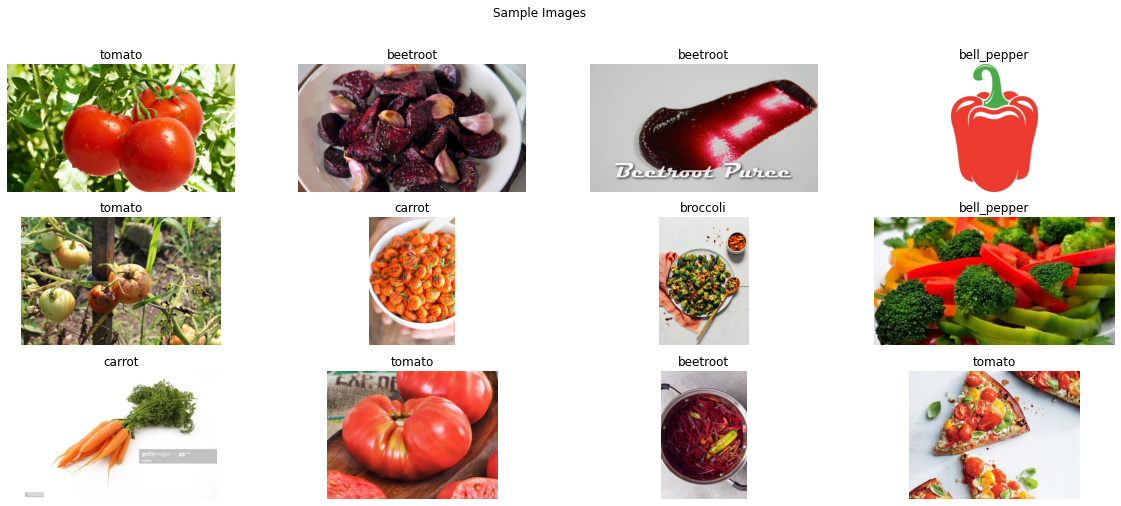

In [43]:
# Your code here
image_samples = np.random.randint(0,high=len(data_list)-1, size=12)

fig = plt.figure(figsize=(20,8))
for i,img_idx in enumerate(image_samples):
    axs = fig.add_subplot(3,4,i+1)
    axs.set_title(data_list[img_idx][0])
    # Read image
    image = cv2.imread(data_list[img_idx][1])
    # convert to rgb
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    plt.imshow(image)
    plt.axis('off')

plt.suptitle("Sample Images")
plt.show()

> Load X as list of image paths, Y as string labels

In [44]:
# Your code here
# Build data x, y
data_x = []
data_y = []
total_images_size = 0

start_time = time.time()
# Load Train/validate data
for label,file_path in data_list:
  # read image
  image = cv2.imread(file_path)
  # convert to rgb
  image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

  # Keep track of size
  total_images_size += image.nbytes / (1024 * 1024.0)
  
  # Resize image
  image = cv2.resize(image, (image_width,image_height), interpolation = cv2.INTER_AREA)

  # Train x
  data_x.append(image)
  # Train y
  data_y.append([label2index[label]])
  
execution_time = (time.time() - start_time)/60.0
print("Execution time (mins)",execution_time)

Execution time (mins) 1.2385862469673157


In [45]:
# Number of times to duplicate the data 
NUM_DUPS = 1

# Convert to numpy array
train_validate_x = np.asarray(data_x*NUM_DUPS)
train_validate_y = np.asarray(data_y*NUM_DUPS)
print("train_validate_x shape:",train_validate_x.shape)
print("train_validate_y shape:",train_validate_y.shape)
print("\n")

# Get memory usage of local variables
display_memory_usage(locals().items())

train_validate_x shape: (2934, 224, 224, 3)
train_validate_y shape: (2934, 1)


             train_processed_x:   2.6 GB
          validate_processed_x: 674.1 MB
              train_validate_x: 421.2 MB
                         image: 147.1 KB
                     data_list:  25.9 KB
                        data_x:  23.2 KB
                        data_y:  23.2 KB
              train_validate_y:  23.0 KB
               large_data_list:  23.0 KB
                       train_x:  20.6 KB
                  ------------------------
                        Total::   3.7 GB


> Split the data in 80/20 train/test

In [46]:
# Your code here
validation_percent = 0.2

# Split data into train / validation
train_processed_x, validate_processed_x, train_processed_y, validate_processed_y = train_test_split(train_validate_x, train_validate_y, test_size=validation_percent) 

# Normalization values to range between 0 and 1
train_processed_x = train_processed_x.astype("float")/255.0
validate_processed_x = validate_processed_x.astype("float")/255.0

# Converts y to binary class matrix (One-hot-encoded)
train_processed_y = to_categorical(train_processed_y, num_classes=num_classes, dtype='float32')
validate_processed_y = to_categorical(validate_processed_y, num_classes=num_classes, dtype='float32')

print("Inputs x:")
print("train_processed_x shape:",train_processed_x.shape)
print("validate_processed_x shape:",validate_processed_x.shape)
print("Outputs y:")
print("train_processed_y shape:",train_processed_y.shape)
print("validate_processed_y shape:",validate_processed_y.shape)

Inputs x:
train_processed_x shape: (2347, 224, 224, 3)
validate_processed_x shape: (587, 224, 224, 3)
Outputs y:
train_processed_y shape: (2347, 5)
validate_processed_y shape: (587, 5)


## **<font color="#324bd9">Model</font>**

> Define a function for building a simple model in Tensorflow. This is for training purposes. You can build your custom model or use some SOTA model

In [47]:
# Build Model
def build_model(image_height, image_width, num_channels, num_classes):
  # Your code here
  # Model input
  input_shape = [image_height, image_width, num_channels] # height, width, channels
  model_input = keras.Input(shape=input_shape)

  # Hidden Layer, Convolution Block
  hidden = keras.layers.Conv2D(filters=64, kernel_size=(3, 3), padding='same', activation='relu')(model_input)
  hidden = keras.layers.Conv2D(filters=64, kernel_size=(3, 3), padding='same', activation='relu')(hidden)
  hidden = keras.layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2))(hidden)

  # Hidden Layer, Convolution Block
  hidden = keras.layers.Conv2D(filters=128, kernel_size=(3, 3), padding='same', activation='relu')(hidden)
  hidden = keras.layers.Conv2D(filters=128, kernel_size=(3, 3), padding='same', activation='relu')(hidden)
  hidden = keras.layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2))(hidden)

  # Flatten
  hidden = keras.layers.Flatten()(hidden)

  #  Hidden Layer, Classification Block
  hidden = keras.layers.Dense(units=64, activation='relu')(hidden)
  hidden = keras.layers.Dense(units=64, activation='relu')(hidden)

  # Output Layer
  output = keras.layers.Dense(units=num_classes, activation='softmax')(hidden)

  model = Model(model_input, output, name='simple_cnn_model')
  
  return model

## **<font color="#324bd9">Build Data Pipelines</font>**

For this section we will be using the `tf.data` API to build a simple but efficient data pipeline. The `tf.data` API enables you to build complex input pipelines from simple, reusable pieces. 

Input pipelines do not load all data to memory and streams data to the model as it is training. Pipelines can stream data from distributed file systems as well as local file systems. So in summary  `tf.data` API will help you as a Data Science Practioner to work with large amounts of data, read from different data formats, and perform complex transformations.


[Reference](https://www.tensorflow.org/guide/data)

> Make the data pipeline using tf.data API. You can use any preprocessing function you deem necessary or important

In [48]:
NUM_DUPS = 1
large_data_list = data_list * NUM_DUPS

# Build data x, y
data_x = [itm[1] for itm in large_data_list]
data_y = [itm[0] for itm in large_data_list]

print("data_list:",len(data_list))
print("data_x:",len(data_x))
print("data_y:",len(data_y))
print("data_x:",data_x[:5])
print("data_y:",data_y[:5])

data_list: 2934
data_x: 2934
data_y: 2934
data_x: ['datasets/vegetables/beetroot/124.jpg', 'datasets/vegetables/beetroot/485.jpg', 'datasets/vegetables/beetroot/511.jpg', 'datasets/vegetables/beetroot/36.jpg', 'datasets/vegetables/beetroot/40.jpg']
data_y: ['beetroot', 'beetroot', 'beetroot', 'beetroot', 'beetroot']


In [49]:
validation_percent = 0.2

# Split data into train / validate
train_x, validate_x, train_y, validate_y = train_test_split(data_x, data_y, test_size=validation_percent)

print("train_x count:",len(train_x))
print("validate_x count:",len(validate_x))

train_x count: 2347
validate_x count: 587


In [50]:
# Your code here
batch_size = 128
train_shuffle_buffer_size = len(train_x)
validation_shuffle_buffer_size = len(validate_x)

# Load Image
def load_image(path, label):
  image = tf.io.read_file(path)
  image = tf.image.decode_jpeg(image, channels=num_channels)
  image = tf.image.resize(image, [image_height,image_width])
  return image, label

# Normalize pixels
def normalize(image, label):
  image = image/255
  return image, label

# Convert all y labels to numbers
train_processed_y = [label2index[label] for label in train_y]
validate_processed_y = [label2index[label] for label in validate_y]

# Converts to y to binary class matrix (One-hot-encoded)
train_processed_y = to_categorical(train_processed_y, num_classes=num_classes, dtype='float32')
validate_processed_y = to_categorical(validate_processed_y, num_classes=num_classes, dtype='float32')

# Create TF Dataset
train_data = tf.data.Dataset.from_tensor_slices((train_x, train_processed_y))
validation_data = tf.data.Dataset.from_tensor_slices((validate_x, validate_processed_y))

#############
# Train data
#############
# Apply all data processing logic
train_data = train_data.shuffle(buffer_size=train_shuffle_buffer_size)
train_data = train_data.map(load_image, num_parallel_calls=AUTOTUNE)
train_data = train_data.map(normalize, num_parallel_calls=AUTOTUNE)
train_data = train_data.batch(batch_size)
train_data = train_data.prefetch(AUTOTUNE)
#train_data = train_data.cache()

##################
# Validation data
##################
# Apply all data processing logic
validation_data = validation_data.shuffle(buffer_size=validation_shuffle_buffer_size)
validation_data = validation_data.map(load_image, num_parallel_calls=AUTOTUNE)
validation_data = validation_data.map(normalize, num_parallel_calls=AUTOTUNE)
validation_data = validation_data.batch(batch_size)
validation_data = validation_data.prefetch(AUTOTUNE)

print("train_data",train_data)
print("validation_data",validation_data)

train_data <PrefetchDataset shapes: ((None, 224, 224, 3), (None, 5)), types: (tf.float32, tf.float32)>
validation_data <PrefetchDataset shapes: ((None, 224, 224, 3), (None, 5)), types: (tf.float32, tf.float32)>


> Visualize 6 images from the first batch of the dataset you made. 

In [51]:
# Your code here

## **<font color="#324bd9">Train using TF Data</font>**

> Train your model using dataset and model you created. Select approriate optimizer, loss function, learning rate etc. Train for 10 epochs

Model: "simple_cnn_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 224, 224, 64)      1792      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 224, 224, 64)      36928     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 112, 112, 64)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 112, 112, 128)     73856     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 112, 112, 128)     147584    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 56, 56, 128)  

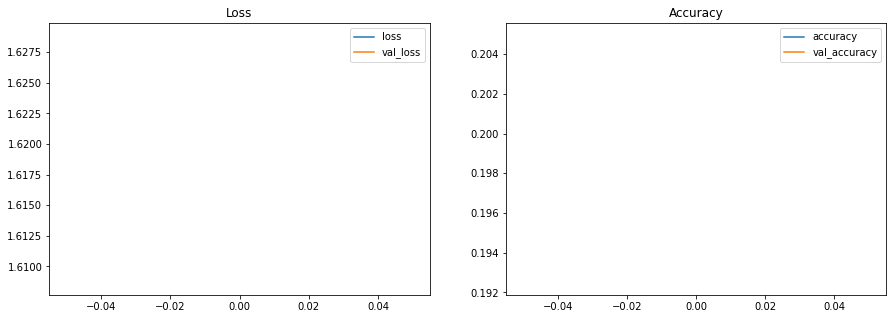

5/5 [==============================] - 7s 1s/step - loss: 1.6289 - accuracy: 0.1925
[1.6288659572601318, 0.19250425696372986]


In [52]:
# Your code here
############################
# Training Params
############################
learning_rate = 0.01
epochs = 1

# Free up memory
K.clear_session()

# Build the model
model = build_model(image_height, image_width, num_channels, num_classes)

# Print the model architecture
print(model.summary())

# Optimizer
optimizer = keras.optimizers.SGD(learning_rate=learning_rate, momentum = 0.001)

# Loss
loss = keras.losses.categorical_crossentropy

# Compile
model.compile(loss=loss,
                  optimizer=optimizer,
                  metrics=['accuracy'])

# Train model
start_time = time.time()
training_results = model.fit(
        train_data,
        validation_data=validation_data,
        epochs=epochs, 
        verbose=1)
execution_time = (time.time() - start_time)/60.0
print("Training execution time (mins)",execution_time)

evaluate_model(model,validation_data, training_results)

## **<font color="#324bd9">TF Records</font>**

> Define a function for creating TF Examples for TF Records

In [53]:
# Your code here
def create_tf_example(item):

  # Read image
  image = tf.io.read_file(item[1])
  image = tf.image.decode_jpeg(image, channels=num_channels)
  image = tf.image.resize(image, [image_height,image_width])
  # # Encode
  # image = tf.cast(image, tf.uint8)
  # image = tf.image.encode_jpeg(image, optimize_size=True, chroma_downsampling=False)
  image = tf.cast(image, tf.uint8)

  # Label
  label = label2index[item[0]]

  # Build feature dict
  feature_dict = {
      'image': tf.train.Feature(bytes_list=tf.train.BytesList(value=[image.numpy().tobytes()])),
      'label': tf.train.Feature(int64_list=tf.train.Int64List(value=[label])),
  }

  example = tf.train.Example(features=tf.train.Features(feature=feature_dict))
  return example

def create_tf_records(data,num_shards=10, prefix='', folder='data'):
  num_records = len(data)
  step_size = num_records//num_shards + 1

  for i in range(0, num_records, step_size):
    print("Creating shard:",(i//step_size)," from records:",i,"to",(i+step_size))
    path = '{}/{}_000{}.tfrecords'.format(folder, prefix, i//step_size)
    print(path)

    # Write the file
    with tf.io.TFRecordWriter(path) as writer:
      # Filter the subset of data to write to tfrecord file
      for item in data[i:i+step_size]:
        tf_example = create_tf_example(item)
        writer.write(tf_example.SerializeToString()) 

> Splitting the dataset into 80/20 train/test

In [54]:
# Your code here
validation_percent = 0.2

# Split data into train / validate
train_xy, validate_xy = train_test_split(large_data_list, test_size=validation_percent)

print("train_xy count:",len(train_xy))
print("validate_xy count:",len(validate_xy))

train_xy count: 2347
validate_xy count: 587


> Create TF Records (3 shards for training and 1 shard for validation)

In [55]:
# Your code here
# Create an output path to store the tfrecords
tfrecords_output_dir = "test_tfrecords"
if os.path.exists(tfrecords_output_dir):
  shutil.rmtree(tfrecords_output_dir)
tf.io.gfile.makedirs(tfrecords_output_dir)

# Take a subset of images
subset_data = large_data_list[:256]
num_shards = 2

# Create TFRecords
create_tf_records(subset_data,num_shards=num_shards, prefix="test", folder=tfrecords_output_dir)

Creating shard: 0  from records: 0 to 129
test_tfrecords/test_0000.tfrecords
Creating shard: 1  from records: 129 to 258
test_tfrecords/test_0001.tfrecords


> Creating dataset using tf.data API and tf records you created above. 
  
  a. Add Image Augmentations (atleast 3)

In [56]:
# Your code here
batch_size = 128

# Read TF Records
feature_description = {
    'image': tf.io.FixedLenFeature([], tf.string),
    'label': tf.io.FixedLenFeature([], tf.int64)
}
# @tf.function
def parse_tfrecord_example(example_proto):
  parsed_example = tf.io.parse_single_example(example_proto, feature_description)

  # Image
  #image = tf.image.decode_jpeg(parsed_example['image'])
  image = tf.io.decode_raw(parsed_example['image'], tf.uint8)
  image.set_shape([num_channels * image_height * image_width])
  image = tf.reshape(image, [image_height, image_width, num_channels])

  # Label
  label = tf.cast(parsed_example['label'], tf.int32)
  label = tf.one_hot(label, num_classes)

  return image, label

# Normalize pixels
def normalize(image, label):
  image = image/255
  return image, label

# Create TF Dataset
sample_dataset = tf.data.Dataset.list_files(tfrecords_output_dir+'/*')
sample_dataset = sample_dataset.flat_map(tf.data.TFRecordDataset)
sample_dataset = sample_dataset.map(parse_tfrecord_example, num_parallel_calls=AUTOTUNE)
sample_dataset = sample_dataset.map(normalize, num_parallel_calls=AUTOTUNE)
sample_dataset = sample_dataset.batch(batch_size)
sample_dataset = sample_dataset.prefetch(buffer_size=AUTOTUNE)
print(sample_dataset)

<PrefetchDataset shapes: ((None, 224, 224, 3), (None, 5)), types: (tf.float32, tf.float32)>


<class 'tensorflow.python.framework.ops.EagerTensor'> (128, 224, 224, 3)
<class 'tensorflow.python.framework.ops.EagerTensor'> (128, 5)
[1. 0. 0. 0. 0.]


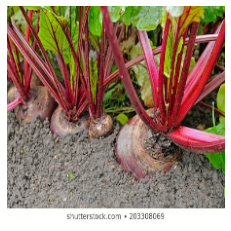

In [57]:
# View data from TFRecord
for batch in sample_dataset.take(1):
  image, label = batch

  print(type(image), image.shape)
  print(type(label),label.shape)

  # Convert image to numpy
  image = image.numpy()[0]
  label = label.numpy()[0]

  print(label)
  plt.imshow(image)
  plt.axis('off')
  plt.show()

In [58]:
# Create an output path to store the tfrecords
tfrecords_output_dir = "mushroom_tfrecords"
if os.path.exists(tfrecords_output_dir):
  shutil.rmtree(tfrecords_output_dir)
tf.io.gfile.makedirs(tfrecords_output_dir)

# Split data into multiple TFRecord shards between 100MB to 200MB
num_shards = 12

# Create TF Records for train
start_time = time.time()
create_tf_records(train_xy,num_shards=num_shards, prefix="train", folder=tfrecords_output_dir)
execution_time = (time.time() - start_time)/60.0
print("Execution time (mins)",execution_time)

# Split data into multiple TFRecord shards between 100MB to 200MB
num_shards = 4

# Create TF Records for validation
start_time = time.time()
create_tf_records(validate_xy,num_shards=num_shards, prefix="val", folder=tfrecords_output_dir)
execution_time = (time.time() - start_time)/60.0
print("Execution time (mins)",execution_time)

Creating shard: 0  from records: 0 to 196
mushroom_tfrecords/train_0000.tfrecords
Creating shard: 1  from records: 196 to 392
mushroom_tfrecords/train_0001.tfrecords
Creating shard: 2  from records: 392 to 588
mushroom_tfrecords/train_0002.tfrecords
Creating shard: 3  from records: 588 to 784
mushroom_tfrecords/train_0003.tfrecords
Creating shard: 4  from records: 784 to 980
mushroom_tfrecords/train_0004.tfrecords
Creating shard: 5  from records: 980 to 1176
mushroom_tfrecords/train_0005.tfrecords
Creating shard: 6  from records: 1176 to 1372
mushroom_tfrecords/train_0006.tfrecords
Creating shard: 7  from records: 1372 to 1568
mushroom_tfrecords/train_0007.tfrecords
Creating shard: 8  from records: 1568 to 1764
mushroom_tfrecords/train_0008.tfrecords
Creating shard: 9  from records: 1764 to 1960
mushroom_tfrecords/train_0009.tfrecords
Creating shard: 10  from records: 1960 to 2156
mushroom_tfrecords/train_00010.tfrecords
Creating shard: 11  from records: 2156 to 2352
mushroom_tfrecords

In [59]:
print("TFRecord folder size:", get_folder_size(tfrecords_output_dir))

TFRecord folder size: 422M


## **<font color="#324bd9">Train using TFRecords</font>**

> Train the same model using TF Records dataset. Try to keep the same training parameters such that you can compare training using TF Records dataset. Train for 10 epochs

In [60]:
# Your code here
batch_size = 128

# Read TF Records
feature_description = {
    'image': tf.io.FixedLenFeature([], tf.string),
    'label': tf.io.FixedLenFeature([], tf.int64)
}

# @tf.function
def parse_tfrecord_example(example_proto):
  parsed_example = tf.io.parse_single_example(example_proto, feature_description)

  # Image
  #image = tf.image.decode_jpeg(parsed_example['image'])
  image = tf.io.decode_raw(parsed_example['image'], tf.uint8)
  image.set_shape([num_channels * image_height * image_width])
  image = tf.reshape(image, [image_height, image_width, num_channels])
  # Label
  label = tf.cast(parsed_example['label'], tf.int32)
  label = tf.one_hot(label, num_classes)

  return image, label

# Normalize pixels
def normalize(image, label):
  image = image/255
  return image, label

# Read the tfrecord files
train_tfrecord_files = tf.data.Dataset.list_files(tfrecords_output_dir+'/train*')
validate_tfrecord_files = tf.data.Dataset.list_files(tfrecords_output_dir+'/val*')

#############
# Train data
#############
train_data = train_tfrecord_files.flat_map(tf.data.TFRecordDataset)
train_data = train_data.map(parse_tfrecord_example, num_parallel_calls=AUTOTUNE)
train_data = train_data.map(normalize, num_parallel_calls=AUTOTUNE)
train_data = train_data.batch(batch_size)
train_data = train_data.prefetch(buffer_size=AUTOTUNE)

##################
# Validation data
##################
validation_data = validate_tfrecord_files.flat_map(tf.data.TFRecordDataset)
validation_data = validation_data.map(parse_tfrecord_example, num_parallel_calls=AUTOTUNE)
validation_data = validation_data.map(normalize, num_parallel_calls=AUTOTUNE)
validation_data = validation_data.batch(batch_size)
validation_data = validation_data.prefetch(buffer_size=AUTOTUNE)

print("train_data",train_data)
print("validation_data",validation_data)

train_data <PrefetchDataset shapes: ((None, 224, 224, 3), (None, 5)), types: (tf.float32, tf.float32)>
validation_data <PrefetchDataset shapes: ((None, 224, 224, 3), (None, 5)), types: (tf.float32, tf.float32)>


Model: "simple_cnn_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 224, 224, 64)      1792      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 224, 224, 64)      36928     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 112, 112, 64)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 112, 112, 128)     73856     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 112, 112, 128)     147584    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 56, 56, 128)  

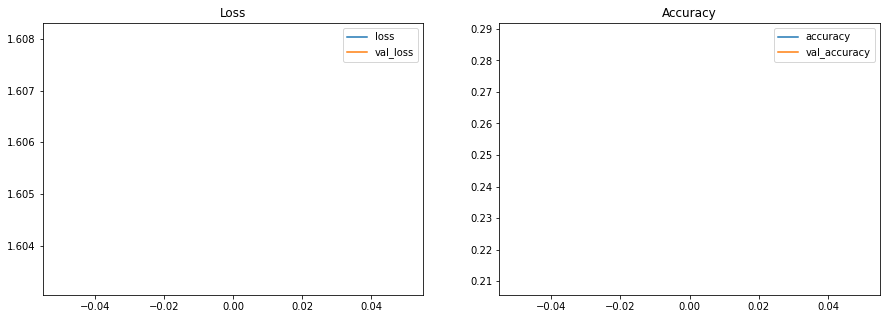

5/5 [==============================] - 2s 406ms/step - loss: 1.6033 - accuracy: 0.2879
[1.603294014930725, 0.2879045903682709]


In [62]:
############################
# Training Params
############################
learning_rate = 0.01
epochs = 1

# Free up memory
K.clear_session()

# Build the model
model = build_model(image_height, image_width, num_channels, num_classes)

# Print the model architecture
print(model.summary())

# Optimizer
optimizer = keras.optimizers.SGD(learning_rate=learning_rate, momentum = 0.001)

# Loss
loss = keras.losses.categorical_crossentropy

# Compile
model.compile(loss=loss,
                  optimizer=optimizer,
                  metrics=['accuracy'])

# Train model
start_time = time.time()
training_results = model.fit(
        train_data,
        validation_data=validation_data,
        epochs=epochs, 
        verbose=1)
execution_time = (time.time() - start_time)/60.0
print("Training execution time (mins)",execution_time)

evaluate_model(model,validation_data, training_results)

## **<font color="#324bd9">Questions</font>**

>1. How much time did it take for training without TF Records?

>2. How much time did it take for training with TF Records?